In [ ]:
# default_exp stats

# fullstream.stats

> Module for statistical computation in the context of particle physics inference.

In [ ]:
#export
import pyhf
pyhf.set_backend(pyhf.tensor.jax_backend())
import numpy as onp
import jax.numpy as np

In [ ]:
#export
def hists_from_nn(nn, params, sigevents, bkgevents, scale=False, use_jax=True):
    '''Create nn-based binned summary statistics from signal and background events. 
    nn should be a predict method that's callable on arguments (data,params), and have a logsoftmax output.'''
    
    # set some arbitrary scale factors
    # todo change
    sig_sf = 0.02 if scale else 1 
    bkg_sf = 0.1 if scale else 1

    sighist = np.sum(np.exp(nn(sigevents,params)),axis=0)*sig_sf
    bkghist = np.sum(np.exp(nn(bkgevents,params)),axis=0)*bkg_sf
    
    if use_jax:
        return sighist, bkghist
    else:
        return onp.asarray(sighist), onp.asarray(bkghist)

In [ ]:
from fullstream.nn import simple_classifier

/home/phinate/miniconda3/lib/python3.7/site-packages/jax/lib/xla_bridge.py:119: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [ ]:
x = simple_classifier(dist=3)

In [ ]:
x.train()


Starting training...
Epoch 0 in 4.02 sec
Training set accuracy 0.87475
Epoch 1 in 3.29 sec
Training set accuracy 0.9105
Epoch 2 in 4.23 sec
Training set accuracy 0.9246


In [ ]:
sighist, bkghist = hists_from_nn(x, x.params, x.gen_sig(1000), x.gen_bkg(1000), scale=True, use_jax=False) 

- 0 --> NN thinks it's background
- 1 --> NN thinks it's signal

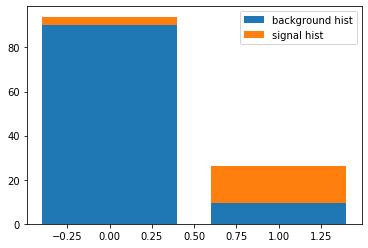

In [ ]:
import matplotlib.pyplot as plt
plt.bar([0,1], bkghist, label='background hist')
plt.bar([0,1], sighist, bottom=bkghist, label='signal hist')
plt.legend()

In [ ]:
#export
def simple_nn_logpdf(nn_pars,nn,pars,data,sig_data,bkg_data,bkg_uncerts,use_jax=False):
        '''Return pyhf.Model.logpdf for a simple two-bin model, containing a signal and background histogram created using hists_from_nn.'''
        tensorlib, _ = pyhf.get_backend()
        
        sig_hist, bkg_hist = hists_from_nn(nn, nn_pars, sig_data, bkg_data, scale=True, use_jax=use_jax) 
        
        spec = {
        'channels': [
            {
                'name': 'singlechannel',
                'samples': [
                    {
                        'name': 'signal',
                        'data': sig_hist,
                        'modifiers': [
                            {'name': 'mu', 'type': 'normfactor', 'data': None}
                        ],
                    },
                    {
                        'name': 'background',
                        'data': bkg_hist,
                        'modifiers': [
                            {
                                'name': 'uncorr_bkguncrt',
                                'type': 'shapesys',
                                'data': bkg_uncerts,
                            }
                        ],
                    },
                ],
            }
        ]
    }
        model = pyhf.Model(spec)

        data += model.config.auxdata
        data = tensorlib.astensor(data)
        pars = tensorlib.astensor(pars)

        # grad only defined for scalar output functions, not [scalar]
        return model.logpdf(pars,data)[0]

In [ ]:
from jax import grad

In [ ]:
# with numpy
simple_nn_logpdf(x.params,
                 nn=x,
                 pars=[1.,1.,1.],
                 data=[100.,20.],
                 sig_data=x.gen_sig(1000),
                 bkg_data=x.gen_bkg(1000),
                 bkg_uncerts=[7,7],
                 use_jax=False)

DeviceArray(-11.35564634, dtype=float64)

In [ ]:
# with jax
grad(simple_nn_logpdf)(x.params,
                       nn=x,
                       pars=[1.,1.,1.],
                       data=[100.,20.],
                       sig_data=x.gen_sig(1000),
                       bkg_data=x.gen_bkg(1000),
                       bkg_uncerts=[7,7],
                       use_jax=True)

[(DeviceArray([[-1.23084898e+01,  5.56208515e+00,  3.23549903e-04,
                 1.93820204e-04,  1.36456146e+01,  0.00000000e+00,
                 0.00000000e+00, -1.01762446e-07,  0.00000000e+00,
                 1.39686193e+01],
               [-1.67865562e+01,  7.58433485e+00,  9.15458222e-05,
                 5.29033096e-05,  1.86071854e+01,  0.00000000e+00,
                 0.00000000e+00,  6.07858965e-07,  0.00000000e+00,
                 1.90502701e+01]], dtype=float32),
  DeviceArray([-3.3381641e+00,  1.5081193e+00,  4.9363491e-05,
                3.0261817e-05,  3.6999431e+00,  0.0000000e+00,
                0.0000000e+00,  1.4742631e-07,  0.0000000e+00,
                3.7882507e+00], dtype=float32)),
 (),
 (DeviceArray([[ 7.3315835e+00, -7.3315835e+00],
               [ 2.1346250e+00, -2.1346250e+00],
               [ 3.3933479e-06, -3.3933479e-06],
               [ 5.3991025e-06, -5.3991025e-06],
               [ 4.8403077e+00, -4.8403077e+00],
               [ 0.000000